<a href="https://colab.research.google.com/github/WVital2025/Code_thesis/blob/main/2D_Algebras_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import layers, activations, initializers

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Function:

In [ ]:
def ftrue(X):
    return np.stack([X[:,0]**2 - X[:,1]**2, X[:,0]**2+X[:,0]*X[:,1]+X[:,1]**2],1)

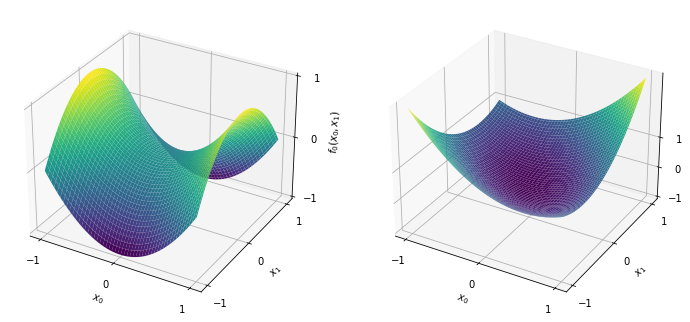

In [ ]:
# Create a meshgrid for x and y values
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# Compute the corresponding z values using the function
Z = ftrue(np.stack([X[:], Y[:]],1))

# Create a 3D plot
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(121, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z[:,0].reshape(100,100), cmap='viridis')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$f_0(x_0,x_1)$')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, Z[:,1].reshape(100,100), cmap='viridis')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$f_1(x_0,x_1)$')

plt.savefig("Figures2D/f_2D.pdf", bbox_inches='tight',pad_inches=0.4)
# Show the plot
plt.show()

In [ ]:
Xtr = 2*np.random.rand(1024,2)-1.0
ytr = ftrue(Xtr)
Xtr.shape,ytr.shape

((1024, 2), (1024, 2))

In [ ]:
Nunits = 128
Nepochs = 1000
opt_method = 'adam'


# def scheduler(epoch, lr):
#     if ((epoch+1)%200)==0:
#         return lr * 0.9
#     else:
#         return lr


# callback = [#kr.callbacks.EarlyStopping(monitor='loss', patience=100),
#            kr.callbacks.LearningRateScheduler(scheduler)]

In [ ]:
class V_Dense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(V_Dense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units,self.algdim),
            initializer="glorot_normal",
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.reduce_sum(
            [tf.experimental.numpy.kron(self.algebra[i,:,:],self.W[:,:,i]) for i in range(self.algdim)]
            ,axis=0)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [ ]:
class V_RealDense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(V_RealDense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.experimental.numpy.kron(np.eye(self.algdim, dtype = np.float32),self.W)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [ ]:
def NetPlot(net,Name=None):
    # Create a meshgrid for x and y values
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)

    # Compute the corresponding z values using the function
    Z = net.predict(np.stack([X.flatten(), Y.flatten()],1))

    # Create a 3D plot
    fig = plt.figure(figsize=(12,10))

    ax = fig.add_subplot(121, projection='3d')

    # Plot the surface
    ax.plot_surface(X, Y, Z[:,0].reshape(100,100), cmap='viridis')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([-1, 0, 1])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$f_0(x_0,x_1)$')

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(X, Y, Z[:,1].reshape(100,100), cmap='viridis')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([-1, 0, 1])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$f_1(x_0,x_1)$')

    if Name is not None:
        plt.savefig("Figures2D/"+Name+".pdf", bbox_inches='tight',pad_inches=0.4)

    # Show the plot
    plt.show()

In [ ]:
def MaxAbs(y_true,y_pred):
    return tf.reduce_max(tf.math.sqrt(tf.reduce_sum(tf.math.square(y_true-y_pred),axis=1)))

# Considered Algebras

## Complex-valued network

In [ ]:
ComplexNumbers = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
ComplexNumbers[:,:,0],ComplexNumbers[:,:,1]

(array([[ 1.,  0.],
        [ 0., -1.]]),
 array([[0., 1.],
        [1., 0.]]))

## Dual Numbers

In [ ]:
DualNumbers = np.stack([np.array([[1.0,0.0],[0.0,0.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
DualNumbers[:,:,0],DualNumbers[:,:,1]

(array([[1., 0.],
        [0., 0.]]),
 array([[0., 1.],
        [1., 0.]]))

## Isomorphic to Dual Numbers

In [ ]:
DualNumbers2 = np.stack([np.array([[3.0/2.0,1.0/2.0],[1.0/2.0,-1.0/2.0]]),np.array([[-1.0/2.0,1.0/2.0],[1.0/2.0,3.0/2.0]])],axis=-1)
DualNumbers2[:,:,0],DualNumbers2[:,:,1]

(array([[ 1.5,  0.5],
        [ 0.5, -0.5]]),
 array([[-0.5,  0.5],
        [ 0.5,  1.5]]))

## Non-degenerate Algebra

In [ ]:
NonDegenerate = np.stack([np.array([[1.0,0.0],[0.0,1.0]]),np.array([[1.0,0.0],[0.0,1.0]])],axis=-1)
NonDegenerate[:,:,0],NonDegenerate[:,:,1],np.linalg.matrix_rank(NonDegenerate.reshape(4,2))

(array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 1)

## Degenerate

In [ ]:
Degenerate = np.stack([np.array([[1.0,0.0],[0.0,1.0]]),np.array([[1.0,1.0],[1.0,1.0]])],axis=-1)
Degenerate[:,:,0],Degenerate[:,:,1],np.linalg.matrix_rank(Degenerate.reshape(4,2))

(array([[1., 0.],
        [0., 1.]]),
 array([[1., 1.],
        [1., 1.]]),
 2)

# Real-valued network

In [ ]:
kr.backend.clear_session()

RealMLP = kr.Sequential([kr.layers.Input(shape=(Xtr.shape[1],)),
                            kr.layers.Dense(Nunits, activation='relu'),
                            kr.layers.Dense(2, use_bias=False, activation = None)])
RealMLP.compile(optimizer=opt_method,loss='mse',metrics=[MaxAbs])
h_Real = RealMLP.fit(Xtr,ytr, epochs=Nepochs, verbose = 1, batch_size=128) #, callbacks=[callback])

RealMLP.summary()

Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.4840 - MaxAbs: 2.6076
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3923 - MaxAbs: 2.4158
Epoch 3/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.3170 - MaxAbs: 2.2384
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2582 - MaxAbs: 2.0886
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2119 - MaxAbs: 1.8603
Epoch 6/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1782 - MaxAbs: 1.7286
Epoch 7/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1522 - MaxAbs: 1.6589
Epoch 8/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1335 - MaxAbs: 1.5282
Epoch 9/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1189 - MaxAbs: 1.4051
Epoch 10/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1064 - MaxAbs: 1.3208
Epoch 11/1000
8/8 [====================

8/8 [==============================] - 0s 2ms/step - loss: 0.0024 - MaxAbs: 0.3337
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0023 - MaxAbs: 0.3246
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0022 - MaxAbs: 0.2891
Epoch 88/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0022 - MaxAbs: 0.3051
Epoch 89/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0021 - MaxAbs: 0.3029
Epoch 90/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0021 - MaxAbs: 0.3117
Epoch 91/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0020 - MaxAbs: 0.2781
Epoch 92/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0020 - MaxAbs: 0.3176
Epoch 93/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - MaxAbs: 0.2956
Epoch 94/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - MaxAbs: 0.2688
Epoch 95/1000
8/8 [=========================

8/8 [==============================] - 0s 2ms/step - loss: 4.1334e-04 - MaxAbs: 0.1613
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0580e-04 - MaxAbs: 0.1466
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.9835e-04 - MaxAbs: 0.1583
Epoch 170/1000
8/8 [==============================] - 0s 1ms/step - loss: 3.9226e-04 - MaxAbs: 0.1612
Epoch 171/1000
8/8 [==============================] - 0s 1ms/step - loss: 3.8416e-04 - MaxAbs: 0.1541
Epoch 172/1000
8/8 [==============================] - 0s 1ms/step - loss: 3.7892e-04 - MaxAbs: 0.1509
Epoch 173/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6998e-04 - MaxAbs: 0.1597
Epoch 174/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6403e-04 - MaxAbs: 0.1538
Epoch 175/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5650e-04 - MaxAbs: 0.1533
Epoch 176/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5122e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.2978e-04 - MaxAbs: 0.0863
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2868e-04 - MaxAbs: 0.0899
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2758e-04 - MaxAbs: 0.0845
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2510e-04 - MaxAbs: 0.0958
Epoch 251/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2366e-04 - MaxAbs: 0.0823
Epoch 252/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2246e-04 - MaxAbs: 0.0864
Epoch 253/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2124e-04 - MaxAbs: 0.0880
Epoch 254/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2035e-04 - MaxAbs: 0.0858
Epoch 255/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1789e-04 - MaxAbs: 0.0828
Epoch 256/1000
8/8 [==============================] - 0s 1ms/step - loss: 1.1813e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 5.6776e-05 - MaxAbs: 0.0557
Epoch 328/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.5536e-05 - MaxAbs: 0.0603
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.4752e-05 - MaxAbs: 0.0534
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.4344e-05 - MaxAbs: 0.0572
Epoch 331/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.4858e-05 - MaxAbs: 0.0581
Epoch 332/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.6509e-05 - MaxAbs: 0.0523
Epoch 333/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.3661e-05 - MaxAbs: 0.0566
Epoch 334/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.3728e-05 - MaxAbs: 0.0549
Epoch 335/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.1965e-05 - MaxAbs: 0.0552
Epoch 336/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.2277e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 2.8091e-05 - MaxAbs: 0.0406
Epoch 408/1000
8/8 [==============================] - 0s 1ms/step - loss: 2.7735e-05 - MaxAbs: 0.0377
Epoch 409/1000
8/8 [==============================] - 0s 1ms/step - loss: 2.7013e-05 - MaxAbs: 0.0396
Epoch 410/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.7268e-05 - MaxAbs: 0.0363
Epoch 411/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.7205e-05 - MaxAbs: 0.0396
Epoch 412/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6637e-05 - MaxAbs: 0.0377
Epoch 413/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6389e-05 - MaxAbs: 0.0355
Epoch 414/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6674e-05 - MaxAbs: 0.0359
Epoch 415/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6393e-05 - MaxAbs: 0.0374
Epoch 416/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6021e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 1ms/step - loss: 1.5740e-05 - MaxAbs: 0.0300
Epoch 488/1000
8/8 [==============================] - 0s 1ms/step - loss: 1.5956e-05 - MaxAbs: 0.0270
Epoch 489/1000
8/8 [==============================] - 0s 1ms/step - loss: 1.5335e-05 - MaxAbs: 0.0256
Epoch 490/1000
8/8 [==============================] - 0s 1ms/step - loss: 1.5361e-05 - MaxAbs: 0.0250
Epoch 491/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5392e-05 - MaxAbs: 0.0260
Epoch 492/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5210e-05 - MaxAbs: 0.0252
Epoch 493/1000
8/8 [==============================] - 0s 1ms/step - loss: 1.5218e-05 - MaxAbs: 0.0273
Epoch 494/1000
8/8 [==============================] - 0s 1ms/step - loss: 1.5301e-05 - MaxAbs: 0.0242
Epoch 495/1000
8/8 [==============================] - 0s 1ms/step - loss: 1.4991e-05 - MaxAbs: 0.0257
Epoch 496/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4996e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.0115e-05 - MaxAbs: 0.0177
Epoch 568/1000
8/8 [==============================] - 0s 1ms/step - loss: 9.9301e-06 - MaxAbs: 0.0206
Epoch 569/1000
8/8 [==============================] - 0s 1ms/step - loss: 1.0267e-05 - MaxAbs: 0.0210
Epoch 570/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.8859e-06 - MaxAbs: 0.0203
Epoch 571/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.6766e-06 - MaxAbs: 0.0212
Epoch 572/1000
8/8 [==============================] - 0s 1ms/step - loss: 9.8120e-06 - MaxAbs: 0.0187
Epoch 573/1000
8/8 [==============================] - 0s 1ms/step - loss: 9.9360e-06 - MaxAbs: 0.0196
Epoch 574/1000
8/8 [==============================] - 0s 1ms/step - loss: 9.5593e-06 - MaxAbs: 0.0197
Epoch 575/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.6922e-06 - MaxAbs: 0.0178
Epoch 576/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.6796e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 8.2458e-06 - MaxAbs: 0.0172
Epoch 648/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.0486e-06 - MaxAbs: 0.0154
Epoch 649/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.8806e-06 - MaxAbs: 0.0171
Epoch 650/1000
8/8 [==============================] - 0s 1ms/step - loss: 7.7189e-06 - MaxAbs: 0.0159
Epoch 651/1000
8/8 [==============================] - 0s 1ms/step - loss: 7.6677e-06 - MaxAbs: 0.0171
Epoch 652/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.5916e-06 - MaxAbs: 0.0141
Epoch 653/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6215e-06 - MaxAbs: 0.0173
Epoch 654/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.7881e-06 - MaxAbs: 0.0148
Epoch 655/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3115e-06 - MaxAbs: 0.0150
Epoch 656/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.8605e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 6.4419e-06 - MaxAbs: 0.0150
Epoch 728/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.5464e-06 - MaxAbs: 0.0148
Epoch 729/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.6678e-06 - MaxAbs: 0.0135
Epoch 730/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4377e-06 - MaxAbs: 0.0137
Epoch 731/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2869e-06 - MaxAbs: 0.0142
Epoch 732/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.3794e-06 - MaxAbs: 0.0131
Epoch 733/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2199e-06 - MaxAbs: 0.0134
Epoch 734/1000
8/8 [==============================] - 0s 1ms/step - loss: 6.3516e-06 - MaxAbs: 0.0129
Epoch 735/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.3101e-06 - MaxAbs: 0.0138
Epoch 736/1000
8/8 [==============================] - 0s 1ms/step - loss: 6.3098e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 6.3867e-06 - MaxAbs: 0.0121
Epoch 808/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.3751e-06 - MaxAbs: 0.0131
Epoch 809/1000
8/8 [==============================] - 0s 1ms/step - loss: 6.2104e-06 - MaxAbs: 0.0116
Epoch 810/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.9546e-06 - MaxAbs: 0.0137
Epoch 811/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0658e-06 - MaxAbs: 0.0128
Epoch 812/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.1858e-06 - MaxAbs: 0.0108
Epoch 813/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0516e-06 - MaxAbs: 0.0135
Epoch 814/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.8304e-06 - MaxAbs: 0.0124
Epoch 815/1000
8/8 [==============================] - 0s 1ms/step - loss: 6.1031e-06 - MaxAbs: 0.0129
Epoch 816/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.8939e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 1ms/step - loss: 5.4103e-06 - MaxAbs: 0.0109
Epoch 888/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.6359e-06 - MaxAbs: 0.0117
Epoch 889/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.7674e-06 - MaxAbs: 0.0109
Epoch 890/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.3844e-06 - MaxAbs: 0.0108
Epoch 891/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.5686e-06 - MaxAbs: 0.0114
Epoch 892/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.8829e-06 - MaxAbs: 0.0105
Epoch 893/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.4120e-06 - MaxAbs: 0.0116
Epoch 894/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.1038e-06 - MaxAbs: 0.0109
Epoch 895/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7556e-06 - MaxAbs: 0.0101
Epoch 896/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.8026e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 1ms/step - loss: 4.5496e-06 - MaxAbs: 0.0096
Epoch 968/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.4036e-06 - MaxAbs: 0.0089
Epoch 969/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.4473e-06 - MaxAbs: 0.0095
Epoch 970/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.1754e-06 - MaxAbs: 0.0087
Epoch 971/1000
8/8 [==============================] - 0s 1ms/step - loss: 4.6276e-06 - MaxAbs: 0.0107
Epoch 972/1000
8/8 [==============================] - 0s 1ms/step - loss: 4.8881e-06 - MaxAbs: 0.0103
Epoch 973/1000
8/8 [==============================] - 0s 1ms/step - loss: 4.4543e-06 - MaxAbs: 0.0100
Epoch 974/1000
8/8 [==============================] - 0s 1ms/step - loss: 4.0984e-06 - MaxAbs: 0.0088
Epoch 975/1000
8/8 [==============================] - 0s 1ms/step - loss: 4.6403e-06 - MaxAbs: 0.0102
Epoch 976/1000
8/8 [==============================] - 0s 1ms/step - loss: 5.2169e-06 - MaxAbs: 0.

313/313 [==============================] - 0s 789us/step


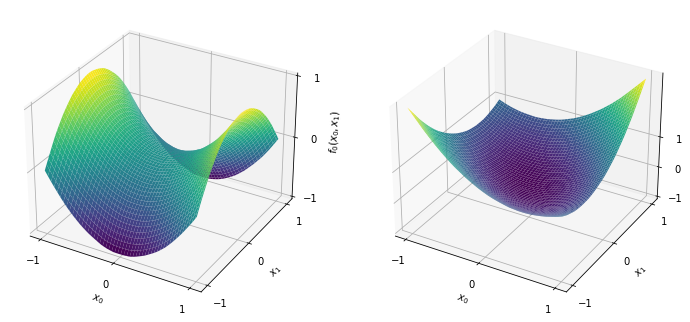

In [ ]:
NetPlot(RealMLP,Name='RealMLP')

In [ ]:
def EvalHypercomplexNetworkR(algebra,Xtr,ytr):
    kr.backend.clear_session()

    MLP_network = kr.Sequential([kr.layers.Input(shape=(Xtr.shape[1],)),
                            V_Dense(Nunits, activation='relu', algebra=algebra),
                            V_RealDense(1, algebra=algebra, use_bias=False, activation = None)])
    print(MLP_network.summary())
    MLP_network.compile(optimizer=opt_method,loss='mse',metrics=[MaxAbs])
    return MLP_network.fit(Xtr,ytr, epochs=Nepochs, verbose = 1, batch_size=128), MLP_network

In [ ]:
h_ComplexR, net_ComplexR = EvalHypercomplexNetworkR(ComplexNumbers,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__real_dense (V_RealDense)  (None, 2)                128       
                                                                 
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.4582 - MaxAbs: 2.5018
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3734 - MaxAbs: 2.4578
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3083 - MaxAbs: 2.2162
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2591 - MaxAbs: 2.0339
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0066 - MaxAbs: 0.4069
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0064 - MaxAbs: 0.4096
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0062 - MaxAbs: 0.3926
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0060 - MaxAbs: 0.3997
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0058 - MaxAbs: 0.3948
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0056 - MaxAbs: 0.4023
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0054 - MaxAbs: 0.3672
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0052 - MaxAbs: 0.3885
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0051 - MaxAbs: 0.3662
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0049 - MaxAbs: 0.3785
Epoch 88/1000
8/8 [=========================

8/8 [==============================] - 0s 2ms/step - loss: 7.2865e-04 - MaxAbs: 0.1799
Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1171e-04 - MaxAbs: 0.1761
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0092e-04 - MaxAbs: 0.1672
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.8729e-04 - MaxAbs: 0.1589
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.7360e-04 - MaxAbs: 0.1442
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.6395e-04 - MaxAbs: 0.1580
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4448e-04 - MaxAbs: 0.1756
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.3797e-04 - MaxAbs: 0.1668
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.3482e-04 - MaxAbs: 0.1628
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.1267e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.9838e-04 - MaxAbs: 0.0969
Epoch 242/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9283e-04 - MaxAbs: 0.0877
Epoch 243/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9168e-04 - MaxAbs: 0.0930
Epoch 244/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.8796e-04 - MaxAbs: 0.0917
Epoch 245/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.8466e-04 - MaxAbs: 0.0880
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.8139e-04 - MaxAbs: 0.0916
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7962e-04 - MaxAbs: 0.0949
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7546e-04 - MaxAbs: 0.0934
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7482e-04 - MaxAbs: 0.0864
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7112e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 7.5982e-05 - MaxAbs: 0.0665
Epoch 322/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3451e-05 - MaxAbs: 0.0604
Epoch 323/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2818e-05 - MaxAbs: 0.0602
Epoch 324/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2890e-05 - MaxAbs: 0.0549
Epoch 325/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1940e-05 - MaxAbs: 0.0543
Epoch 326/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1172e-05 - MaxAbs: 0.0574
Epoch 327/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0383e-05 - MaxAbs: 0.0600
Epoch 328/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0208e-05 - MaxAbs: 0.0562
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0792e-05 - MaxAbs: 0.0586
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.9228e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 3.6065e-05 - MaxAbs: 0.0377
Epoch 402/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6616e-05 - MaxAbs: 0.0388
Epoch 403/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5055e-05 - MaxAbs: 0.0413
Epoch 404/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.4835e-05 - MaxAbs: 0.0392
Epoch 405/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5628e-05 - MaxAbs: 0.0409
Epoch 406/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.3679e-05 - MaxAbs: 0.0418
Epoch 407/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.3026e-05 - MaxAbs: 0.0366
Epoch 408/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.3240e-05 - MaxAbs: 0.0378
Epoch 409/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.3618e-05 - MaxAbs: 0.0366
Epoch 410/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.3335e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.9347e-05 - MaxAbs: 0.0301
Epoch 482/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9021e-05 - MaxAbs: 0.0285
Epoch 483/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9542e-05 - MaxAbs: 0.0284
Epoch 484/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9636e-05 - MaxAbs: 0.0289
Epoch 485/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9075e-05 - MaxAbs: 0.0287
Epoch 486/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.0009e-05 - MaxAbs: 0.0284
Epoch 487/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9791e-05 - MaxAbs: 0.0269
Epoch 488/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9886e-05 - MaxAbs: 0.0285
Epoch 489/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.0217e-05 - MaxAbs: 0.0297
Epoch 490/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.8811e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.2365e-05 - MaxAbs: 0.0216
Epoch 562/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1830e-05 - MaxAbs: 0.0201
Epoch 563/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2538e-05 - MaxAbs: 0.0223
Epoch 564/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2496e-05 - MaxAbs: 0.0202
Epoch 565/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2024e-05 - MaxAbs: 0.0205
Epoch 566/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2048e-05 - MaxAbs: 0.0209
Epoch 567/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.3428e-05 - MaxAbs: 0.0224
Epoch 568/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2868e-05 - MaxAbs: 0.0195
Epoch 569/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2350e-05 - MaxAbs: 0.0208
Epoch 570/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2368e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 8.8867e-06 - MaxAbs: 0.0167
Epoch 642/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.9323e-06 - MaxAbs: 0.0176
Epoch 643/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.1700e-06 - MaxAbs: 0.0170
Epoch 644/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0642e-05 - MaxAbs: 0.0166
Epoch 645/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0147e-05 - MaxAbs: 0.0176
Epoch 646/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3799e-06 - MaxAbs: 0.0165
Epoch 647/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.0889e-06 - MaxAbs: 0.0164
Epoch 648/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.9302e-06 - MaxAbs: 0.0165
Epoch 649/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.4712e-06 - MaxAbs: 0.0176
Epoch 650/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.0019e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 6.8720e-06 - MaxAbs: 0.0130
Epoch 722/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1691e-06 - MaxAbs: 0.0143
Epoch 723/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2848e-06 - MaxAbs: 0.0138
Epoch 724/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.7094e-06 - MaxAbs: 0.0140
Epoch 725/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2717e-06 - MaxAbs: 0.0142
Epoch 726/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1215e-06 - MaxAbs: 0.0150
Epoch 727/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2153e-06 - MaxAbs: 0.0139
Epoch 728/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.5499e-06 - MaxAbs: 0.0133
Epoch 729/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.7383e-06 - MaxAbs: 0.0135
Epoch 730/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2060e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 5.9007e-06 - MaxAbs: 0.0125
Epoch 802/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0349e-06 - MaxAbs: 0.0127
Epoch 803/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4688e-06 - MaxAbs: 0.0126
Epoch 804/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4303e-06 - MaxAbs: 0.0125
Epoch 805/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2437e-06 - MaxAbs: 0.0120
Epoch 806/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0571e-06 - MaxAbs: 0.0127
Epoch 807/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.6474e-06 - MaxAbs: 0.0116
Epoch 808/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4517e-06 - MaxAbs: 0.0119
Epoch 809/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4647e-06 - MaxAbs: 0.0121
Epoch 810/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.8137e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 5.4724e-06 - MaxAbs: 0.0109
Epoch 882/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.1257e-06 - MaxAbs: 0.0101
Epoch 883/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.6602e-06 - MaxAbs: 0.0100
Epoch 884/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.3620e-06 - MaxAbs: 0.0109
Epoch 885/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.6606e-06 - MaxAbs: 0.0110
Epoch 886/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.3237e-06 - MaxAbs: 0.0096
Epoch 887/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.6558e-06 - MaxAbs: 0.0101
Epoch 888/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.4179e-06 - MaxAbs: 0.0102
Epoch 889/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.7613e-06 - MaxAbs: 0.0111
Epoch 890/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.4824e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 3.8695e-06 - MaxAbs: 0.0083
Epoch 962/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.2739e-06 - MaxAbs: 0.0095
Epoch 963/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0518e-06 - MaxAbs: 0.0093
Epoch 964/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.6707e-06 - MaxAbs: 0.0083
Epoch 965/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7863e-06 - MaxAbs: 0.0089
Epoch 966/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0259e-06 - MaxAbs: 0.0091
Epoch 967/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.9577e-06 - MaxAbs: 0.0087
Epoch 968/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.2792e-06 - MaxAbs: 0.0094
Epoch 969/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.8807e-06 - MaxAbs: 0.0080
Epoch 970/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.4543e-06 - MaxAbs: 0.

313/313 [==============================] - 0s 872us/step


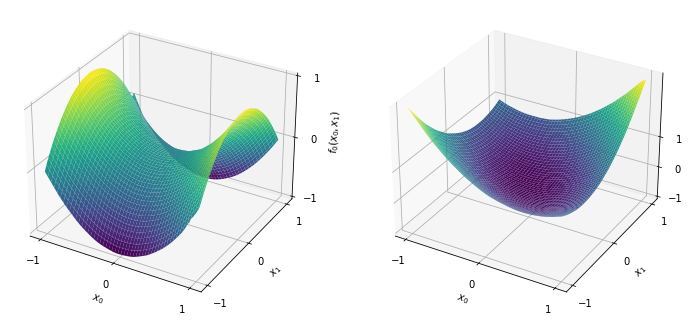

In [ ]:
NetPlot(net_ComplexR,Name="net_ComplexR")

In [ ]:
h_DualR, net_DualR = EvalHypercomplexNetworkR(DualNumbers,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__real_dense (V_RealDense)  (None, 2)                128       
                                                                 
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.4511 - MaxAbs: 2.4886
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3630 - MaxAbs: 2.3022
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2928 - MaxAbs: 2.1997
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2372 - MaxAbs: 1.9919
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0450 - MaxAbs: 0.6983
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0449 - MaxAbs: 0.7037
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0448 - MaxAbs: 0.7076
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0448 - MaxAbs: 0.6991
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0446 - MaxAbs: 0.7072
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0446 - MaxAbs: 0.7103
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0446 - MaxAbs: 0.7039
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0445 - MaxAbs: 0.7138
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0445 - MaxAbs: 0.7027
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0444 - MaxAbs: 0.6982
Epoch 88/1000
8/8 [=========================

Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0428 - MaxAbs: 0.6765
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0428 - MaxAbs: 0.6709
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0428 - MaxAbs: 0.6742
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0428 - MaxAbs: 0.6762
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0428 - MaxAbs: 0.6670
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0427 - MaxAbs: 0.6655
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0427 - MaxAbs: 0.6788
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0428 - MaxAbs: 0.6754
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0427 - MaxAbs: 0.6632
Epoch 171/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0427 - MaxAbs: 0.6713
Epoch 172/1000
8/8 [

8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6631
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0425 - MaxAbs: 0.6603
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0425 - MaxAbs: 0.6678
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0425 - MaxAbs: 0.6579
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6697
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0425 - MaxAbs: 0.6744
Epoch 251/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6706
Epoch 252/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6675
Epoch 253/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0425 - MaxAbs: 0.6661
Epoch 254/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6651
Epoch 255/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6732
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6653
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6679
Epoch 331/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6768
Epoch 332/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0425 - MaxAbs: 0.6633
Epoch 333/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6692
Epoch 334/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6698
Epoch 335/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6655
Epoch 336/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6647
Epoch 337/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6722
Epoch 338/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6668
Epoch 412/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6699
Epoch 413/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6660
Epoch 414/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6690
Epoch 415/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6625
Epoch 416/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6659
Epoch 417/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6716
Epoch 418/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6710
Epoch 419/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6654
Epoch 420/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6672
Epoch 421/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6640
Epoch 495/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6665
Epoch 496/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6609
Epoch 497/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6768
Epoch 498/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6792
Epoch 499/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6703
Epoch 500/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6626
Epoch 501/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6693
Epoch 502/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6655
Epoch 503/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6669
Epoch 504/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6673
Epoch 578/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6719
Epoch 579/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6686
Epoch 580/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6627
Epoch 581/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6666
Epoch 582/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6724
Epoch 583/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6668
Epoch 584/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6664
Epoch 585/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6640
Epoch 586/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6633
Epoch 587/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6666
Epoch 661/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6614
Epoch 662/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6624
Epoch 663/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6664
Epoch 664/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6488
Epoch 665/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6713
Epoch 666/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6693
Epoch 667/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6658
Epoch 668/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6632
Epoch 669/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6656
Epoch 670/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6623
Epoch 744/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6681
Epoch 745/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6702
Epoch 746/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6494
Epoch 747/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6607
Epoch 748/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6681
Epoch 749/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6737
Epoch 750/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6701
Epoch 751/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6654
Epoch 752/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6595
Epoch 753/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6653
Epoch 827/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6704
Epoch 828/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6613
Epoch 829/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6658
Epoch 830/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6618
Epoch 831/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6685
Epoch 832/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6603
Epoch 833/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6689
Epoch 834/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6605
Epoch 835/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6666
Epoch 836/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6614
Epoch 910/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6645
Epoch 911/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6586
Epoch 912/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6614
Epoch 913/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6672
Epoch 914/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6569
Epoch 915/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6641
Epoch 916/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6590
Epoch 917/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6647
Epoch 918/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6702
Epoch 919/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6629
Epoch 993/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6766
Epoch 994/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6744
Epoch 995/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6601
Epoch 996/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6653
Epoch 997/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6695
Epoch 998/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6679
Epoch 999/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6635
Epoch 1000/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6649


313/313 [==============================] - 0s 844us/step


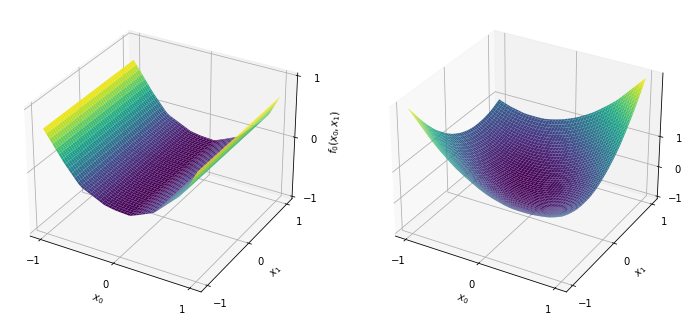

In [ ]:
NetPlot(net_DualR,Name="net_DualR")

In [ ]:
h_Dual2R, net_Dual2R  = EvalHypercomplexNetworkR(DualNumbers2,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__real_dense (V_RealDense)  (None, 2)                128       
                                                                 
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.5191 - MaxAbs: 2.6343
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3937 - MaxAbs: 2.3463
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3052 - MaxAbs: 2.2471
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2400 - MaxAbs: 1.9611
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0471 - MaxAbs: 0.8530
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0463 - MaxAbs: 0.8307
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0452 - MaxAbs: 0.8000
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0443 - MaxAbs: 0.7779
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0433 - MaxAbs: 0.8137
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.7826
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0413 - MaxAbs: 0.7985
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0401 - MaxAbs: 0.7712
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0392 - MaxAbs: 0.7611
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0381 - MaxAbs: 0.8077
Epoch 88/1000
8/8 [=========================

Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0056 - MaxAbs: 0.3464
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0054 - MaxAbs: 0.3747
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0053 - MaxAbs: 0.3277
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0052 - MaxAbs: 0.3453
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0051 - MaxAbs: 0.3557
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0050 - MaxAbs: 0.3460
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0049 - MaxAbs: 0.3329
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0048 - MaxAbs: 0.3211
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0047 - MaxAbs: 0.3531
Epoch 171/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0046 - MaxAbs: 0.3247
Epoch 172/1000
8/8 [

8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - MaxAbs: 0.2016
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - MaxAbs: 0.1973
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - MaxAbs: 0.1830
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - MaxAbs: 0.1964
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - MaxAbs: 0.1793
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - MaxAbs: 0.1949
Epoch 251/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - MaxAbs: 0.1764
Epoch 252/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - MaxAbs: 0.1890
Epoch 253/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - MaxAbs: 0.1801
Epoch 254/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - MaxAbs: 0.1811
Epoch 255/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 4.2182e-04 - MaxAbs: 0.1175
Epoch 327/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.2037e-04 - MaxAbs: 0.1191
Epoch 328/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.1243e-04 - MaxAbs: 0.1197
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0889e-04 - MaxAbs: 0.1191
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.1363e-04 - MaxAbs: 0.1088
Epoch 331/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.1041e-04 - MaxAbs: 0.1223
Epoch 332/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0187e-04 - MaxAbs: 0.1244
Epoch 333/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.9289e-04 - MaxAbs: 0.1163
Epoch 334/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.8763e-04 - MaxAbs: 0.1217
Epoch 335/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.8150e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 2.1193e-04 - MaxAbs: 0.0815
Epoch 407/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.1132e-04 - MaxAbs: 0.0812
Epoch 408/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.0828e-04 - MaxAbs: 0.0778
Epoch 409/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.1238e-04 - MaxAbs: 0.0839
Epoch 410/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.1290e-04 - MaxAbs: 0.0789
Epoch 411/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.0615e-04 - MaxAbs: 0.0761
Epoch 412/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9943e-04 - MaxAbs: 0.0753
Epoch 413/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9976e-04 - MaxAbs: 0.0780
Epoch 414/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9838e-04 - MaxAbs: 0.0771
Epoch 415/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.9785e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.3403e-04 - MaxAbs: 0.0603
Epoch 487/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.3128e-04 - MaxAbs: 0.0552
Epoch 488/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.3025e-04 - MaxAbs: 0.0572
Epoch 489/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.3181e-04 - MaxAbs: 0.0593
Epoch 490/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2773e-04 - MaxAbs: 0.0557
Epoch 491/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2736e-04 - MaxAbs: 0.0592
Epoch 492/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2914e-04 - MaxAbs: 0.0604
Epoch 493/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2754e-04 - MaxAbs: 0.0555
Epoch 494/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2894e-04 - MaxAbs: 0.0565
Epoch 495/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.3206e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 9.1083e-05 - MaxAbs: 0.0447
Epoch 567/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.9539e-05 - MaxAbs: 0.0447
Epoch 568/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.8300e-05 - MaxAbs: 0.0489
Epoch 569/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.4253e-05 - MaxAbs: 0.0445
Epoch 570/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.0671e-05 - MaxAbs: 0.0456
Epoch 571/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.2577e-05 - MaxAbs: 0.0473
Epoch 572/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.4419e-05 - MaxAbs: 0.0465
Epoch 573/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.0835e-05 - MaxAbs: 0.0459
Epoch 574/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3458e-05 - MaxAbs: 0.0463
Epoch 575/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.2432e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 7.6109e-05 - MaxAbs: 0.0366
Epoch 647/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.5040e-05 - MaxAbs: 0.0358
Epoch 648/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6108e-05 - MaxAbs: 0.0371
Epoch 649/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6317e-05 - MaxAbs: 0.0378
Epoch 650/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.1027e-05 - MaxAbs: 0.0370
Epoch 651/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6256e-05 - MaxAbs: 0.0392
Epoch 652/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4012e-05 - MaxAbs: 0.0371
Epoch 653/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2070e-05 - MaxAbs: 0.0382
Epoch 654/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0844e-05 - MaxAbs: 0.0361
Epoch 655/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0970e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 6.2687e-05 - MaxAbs: 0.0311
Epoch 727/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0140e-05 - MaxAbs: 0.0324
Epoch 728/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2608e-05 - MaxAbs: 0.0311
Epoch 729/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.5325e-05 - MaxAbs: 0.0320
Epoch 730/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.5349e-05 - MaxAbs: 0.0299
Epoch 731/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.6227e-05 - MaxAbs: 0.0329
Epoch 732/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1862e-05 - MaxAbs: 0.0330
Epoch 733/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.8598e-05 - MaxAbs: 0.0335
Epoch 734/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.5994e-05 - MaxAbs: 0.0326
Epoch 735/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.9507e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 5.6014e-05 - MaxAbs: 0.0281
Epoch 807/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.9558e-05 - MaxAbs: 0.0290
Epoch 808/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.8547e-05 - MaxAbs: 0.0270
Epoch 809/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2437e-05 - MaxAbs: 0.0291
Epoch 810/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0349e-05 - MaxAbs: 0.0270
Epoch 811/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.9797e-05 - MaxAbs: 0.0300
Epoch 812/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.4891e-05 - MaxAbs: 0.0277
Epoch 813/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.4726e-05 - MaxAbs: 0.0288
Epoch 814/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.4041e-05 - MaxAbs: 0.0282
Epoch 815/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.3599e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 4.9254e-05 - MaxAbs: 0.0275
Epoch 887/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.9145e-05 - MaxAbs: 0.0267
Epoch 888/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.6932e-05 - MaxAbs: 0.0251
Epoch 889/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7672e-05 - MaxAbs: 0.0263
Epoch 890/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.8901e-05 - MaxAbs: 0.0251
Epoch 891/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.6179e-05 - MaxAbs: 0.0279
Epoch 892/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.9264e-05 - MaxAbs: 0.0253
Epoch 893/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7732e-05 - MaxAbs: 0.0271
Epoch 894/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7531e-05 - MaxAbs: 0.0263
Epoch 895/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.0243e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 4.1154e-05 - MaxAbs: 0.0250
Epoch 967/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.1652e-05 - MaxAbs: 0.0243
Epoch 968/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0601e-05 - MaxAbs: 0.0237
Epoch 969/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.1885e-05 - MaxAbs: 0.0243
Epoch 970/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0267e-05 - MaxAbs: 0.0234
Epoch 971/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.1876e-05 - MaxAbs: 0.0242
Epoch 972/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.2180e-05 - MaxAbs: 0.0241
Epoch 973/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.2355e-05 - MaxAbs: 0.0233
Epoch 974/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.4403e-05 - MaxAbs: 0.0260
Epoch 975/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.6036e-05 - MaxAbs: 0.

313/313 [==============================] - 0s 854us/step


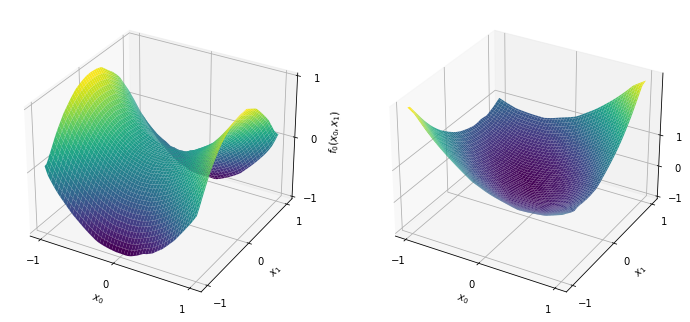

In [ ]:
NetPlot(net_Dual2R,Name="net_Dual2R")

In [ ]:
h_NonDegenerateR, net_NonDegenerateR = EvalHypercomplexNetworkR(NonDegenerate,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__real_dense (V_RealDense)  (None, 2)                128       
                                                                 
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.3985 - MaxAbs: 2.4305
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3260 - MaxAbs: 2.1939
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2688 - MaxAbs: 2.0770
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2239 - MaxAbs: 1.9653
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0068 - MaxAbs: 0.4581
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0066 - MaxAbs: 0.3975
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0064 - MaxAbs: 0.4106
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0062 - MaxAbs: 0.4207
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0060 - MaxAbs: 0.3873
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0058 - MaxAbs: 0.4173
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0056 - MaxAbs: 0.4144
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0054 - MaxAbs: 0.4059
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0053 - MaxAbs: 0.3720
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0051 - MaxAbs: 0.3551
Epoch 88/1000
8/8 [=========================

8/8 [==============================] - 0s 2ms/step - loss: 6.7939e-04 - MaxAbs: 0.1760
Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.6619e-04 - MaxAbs: 0.1828
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.5196e-04 - MaxAbs: 0.1892
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.3933e-04 - MaxAbs: 0.1833
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2159e-04 - MaxAbs: 0.1883
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.1008e-04 - MaxAbs: 0.1931
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0313e-04 - MaxAbs: 0.1739
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.8759e-04 - MaxAbs: 0.1680
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.7919e-04 - MaxAbs: 0.1519
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.6795e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.8278e-04 - MaxAbs: 0.0916
Epoch 242/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.8024e-04 - MaxAbs: 0.0931
Epoch 243/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7863e-04 - MaxAbs: 0.0921
Epoch 244/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7721e-04 - MaxAbs: 0.0958
Epoch 245/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7470e-04 - MaxAbs: 0.0896
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6987e-04 - MaxAbs: 0.0906
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6939e-04 - MaxAbs: 0.0983
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6699e-04 - MaxAbs: 0.0995
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6564e-04 - MaxAbs: 0.0956
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6236e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 7.2535e-05 - MaxAbs: 0.0631
Epoch 322/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1159e-05 - MaxAbs: 0.0586
Epoch 323/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1954e-05 - MaxAbs: 0.0519
Epoch 324/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2679e-05 - MaxAbs: 0.0601
Epoch 325/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0395e-05 - MaxAbs: 0.0602
Epoch 326/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1047e-05 - MaxAbs: 0.0650
Epoch 327/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1633e-05 - MaxAbs: 0.0550
Epoch 328/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0820e-05 - MaxAbs: 0.0615
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.8260e-05 - MaxAbs: 0.0661
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.6406e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 3.8229e-05 - MaxAbs: 0.0420
Epoch 402/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.8328e-05 - MaxAbs: 0.0412
Epoch 403/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6429e-05 - MaxAbs: 0.0458
Epoch 404/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6609e-05 - MaxAbs: 0.0427
Epoch 405/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6784e-05 - MaxAbs: 0.0414
Epoch 406/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6190e-05 - MaxAbs: 0.0432
Epoch 407/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6124e-05 - MaxAbs: 0.0418
Epoch 408/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5903e-05 - MaxAbs: 0.0422
Epoch 409/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5886e-05 - MaxAbs: 0.0419
Epoch 410/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6417e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 2.2359e-05 - MaxAbs: 0.0290
Epoch 482/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2358e-05 - MaxAbs: 0.0301
Epoch 483/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.1864e-05 - MaxAbs: 0.0327
Epoch 484/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.1930e-05 - MaxAbs: 0.0305
Epoch 485/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2179e-05 - MaxAbs: 0.0286
Epoch 486/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.1559e-05 - MaxAbs: 0.0298
Epoch 487/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2880e-05 - MaxAbs: 0.0284
Epoch 488/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2251e-05 - MaxAbs: 0.0282
Epoch 489/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2215e-05 - MaxAbs: 0.0303
Epoch 490/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2103e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.4527e-05 - MaxAbs: 0.0214
Epoch 562/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4651e-05 - MaxAbs: 0.0205
Epoch 563/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4715e-05 - MaxAbs: 0.0232
Epoch 564/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4620e-05 - MaxAbs: 0.0224
Epoch 565/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4356e-05 - MaxAbs: 0.0213
Epoch 566/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5065e-05 - MaxAbs: 0.0209
Epoch 567/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4017e-05 - MaxAbs: 0.0218
Epoch 568/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4348e-05 - MaxAbs: 0.0206
Epoch 569/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6421e-05 - MaxAbs: 0.0235
Epoch 570/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4691e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.0816e-05 - MaxAbs: 0.0189
Epoch 642/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0053e-05 - MaxAbs: 0.0181
Epoch 643/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0668e-05 - MaxAbs: 0.0183
Epoch 644/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0781e-05 - MaxAbs: 0.0176
Epoch 645/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1359e-05 - MaxAbs: 0.0178
Epoch 646/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0797e-05 - MaxAbs: 0.0167
Epoch 647/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1495e-05 - MaxAbs: 0.0177
Epoch 648/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1931e-05 - MaxAbs: 0.0167
Epoch 649/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0913e-05 - MaxAbs: 0.0189
Epoch 650/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0889e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 8.8420e-06 - MaxAbs: 0.0144
Epoch 722/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.6575e-06 - MaxAbs: 0.0155
Epoch 723/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.2687e-06 - MaxAbs: 0.0140
Epoch 724/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.0735e-06 - MaxAbs: 0.0147
Epoch 725/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.9666e-06 - MaxAbs: 0.0149
Epoch 726/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.5528e-06 - MaxAbs: 0.0132
Epoch 727/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.8065e-06 - MaxAbs: 0.0156
Epoch 728/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.2021e-06 - MaxAbs: 0.0155
Epoch 729/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.0705e-06 - MaxAbs: 0.0154
Epoch 730/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.5925e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 8.1823e-06 - MaxAbs: 0.0138
Epoch 802/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4156e-06 - MaxAbs: 0.0124
Epoch 803/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0529e-06 - MaxAbs: 0.0138
Epoch 804/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4883e-06 - MaxAbs: 0.0128
Epoch 805/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.5381e-06 - MaxAbs: 0.0130
Epoch 806/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.8410e-06 - MaxAbs: 0.0115
Epoch 807/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3661e-06 - MaxAbs: 0.0127
Epoch 808/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.5958e-06 - MaxAbs: 0.0136
Epoch 809/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.2185e-06 - MaxAbs: 0.0123
Epoch 810/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6799e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 6.3934e-06 - MaxAbs: 0.0128
Epoch 882/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0121e-06 - MaxAbs: 0.0105
Epoch 883/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.8138e-06 - MaxAbs: 0.0121
Epoch 884/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1290e-06 - MaxAbs: 0.0117
Epoch 885/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0854e-06 - MaxAbs: 0.0113
Epoch 886/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3695e-06 - MaxAbs: 0.0107
Epoch 887/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3038e-06 - MaxAbs: 0.0123
Epoch 888/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3428e-06 - MaxAbs: 0.0114
Epoch 889/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4752e-06 - MaxAbs: 0.0106
Epoch 890/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.6163e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 6.0644e-06 - MaxAbs: 0.0104
Epoch 962/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0574e-06 - MaxAbs: 0.0107
Epoch 963/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.7553e-06 - MaxAbs: 0.0102
Epoch 964/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.9639e-06 - MaxAbs: 0.0099
Epoch 965/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0647e-06 - MaxAbs: 0.0097
Epoch 966/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.5177e-06 - MaxAbs: 0.0106
Epoch 967/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.2261e-06 - MaxAbs: 0.0122
Epoch 968/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.4192e-06 - MaxAbs: 0.0127
Epoch 969/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.7090e-06 - MaxAbs: 0.0117
Epoch 970/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.6767e-06 - MaxAbs: 0.

313/313 [==============================] - 0s 831us/step


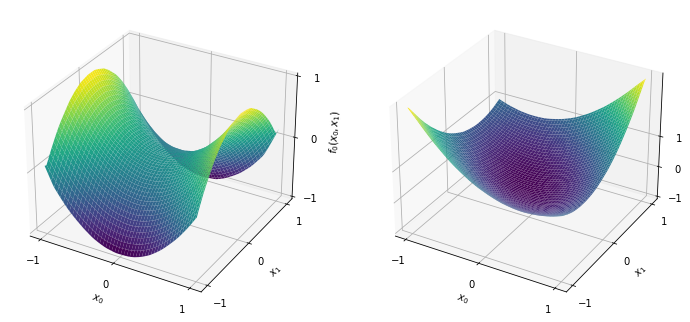

In [ ]:
NetPlot(net_NonDegenerateR,Name="net_NonDegenerateR")

In [ ]:
h_DegenerateR, net_DegenerateR  = EvalHypercomplexNetworkR(Degenerate,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__real_dense (V_RealDense)  (None, 2)                128       
                                                                 
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.3331 - MaxAbs: 2.1817
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2336 - MaxAbs: 1.8178
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1747 - MaxAbs: 1.5626
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1450 - MaxAbs: 1.3097
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0176 - MaxAbs: 0.5945
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0174 - MaxAbs: 0.5795
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0173 - MaxAbs: 0.5840
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0171 - MaxAbs: 0.5630
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0170 - MaxAbs: 0.5638
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0169 - MaxAbs: 0.5698
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0167 - MaxAbs: 0.5664
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0167 - MaxAbs: 0.5789
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0165 - MaxAbs: 0.5511
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0163 - MaxAbs: 0.5606
Epoch 88/1000
8/8 [=========================

Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0140 - MaxAbs: 0.5194
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0139 - MaxAbs: 0.5504
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0140 - MaxAbs: 0.5336
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0139 - MaxAbs: 0.5503
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0139 - MaxAbs: 0.5539
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0140 - MaxAbs: 0.5163
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0140 - MaxAbs: 0.5290
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0139 - MaxAbs: 0.5454
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0139 - MaxAbs: 0.5200
Epoch 171/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0139 - MaxAbs: 0.5379
Epoch 172/1000
8/8 [

8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5478
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5332
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5395
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5113
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5339
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5485
Epoch 251/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5425
Epoch 252/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5229
Epoch 253/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5360
Epoch 254/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5302
Epoch 255/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5373
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5437
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5524
Epoch 331/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5131
Epoch 332/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5285
Epoch 333/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5345
Epoch 334/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5420
Epoch 335/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5475
Epoch 336/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5293
Epoch 337/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5175
Epoch 338/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5242
Epoch 412/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5406
Epoch 413/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5550
Epoch 414/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5432
Epoch 415/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5331
Epoch 416/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5394
Epoch 417/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5369
Epoch 418/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5500
Epoch 419/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5246
Epoch 420/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5264
Epoch 421/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5536
Epoch 495/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5512
Epoch 496/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5382
Epoch 497/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5521
Epoch 498/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5390
Epoch 499/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5408
Epoch 500/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5272
Epoch 501/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5320
Epoch 502/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5343
Epoch 503/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5348
Epoch 504/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5461
Epoch 578/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5474
Epoch 579/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5311
Epoch 580/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5406
Epoch 581/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5247
Epoch 582/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5445
Epoch 583/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5557
Epoch 584/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5481
Epoch 585/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5491
Epoch 586/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5360
Epoch 587/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5341
Epoch 661/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5416
Epoch 662/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5521
Epoch 663/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5338
Epoch 664/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5437
Epoch 665/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5446
Epoch 666/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5495
Epoch 667/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5367
Epoch 668/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5366
Epoch 669/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5387
Epoch 670/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5431
Epoch 744/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5497
Epoch 745/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5065
Epoch 746/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5345
Epoch 747/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5422
Epoch 748/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5299
Epoch 749/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5173
Epoch 750/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5365
Epoch 751/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5247
Epoch 752/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5492
Epoch 753/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5409
Epoch 827/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5372
Epoch 828/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5256
Epoch 829/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5294
Epoch 830/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0137 - MaxAbs: 0.5227
Epoch 831/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5294
Epoch 832/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5554
Epoch 833/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5338
Epoch 834/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0136 - MaxAbs: 0.5451
Epoch 835/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5347
Epoch 836/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5348
Epoch 910/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5465
Epoch 911/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5567
Epoch 912/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5329
Epoch 913/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5365
Epoch 914/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5383
Epoch 915/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5406
Epoch 916/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5355
Epoch 917/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5431
Epoch 918/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5378
Epoch 919/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5394
Epoch 993/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5277
Epoch 994/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5381
Epoch 995/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5566
Epoch 996/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5387
Epoch 997/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5485
Epoch 998/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5415
Epoch 999/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5260
Epoch 1000/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0135 - MaxAbs: 0.5449


313/313 [==============================] - 0s 825us/step


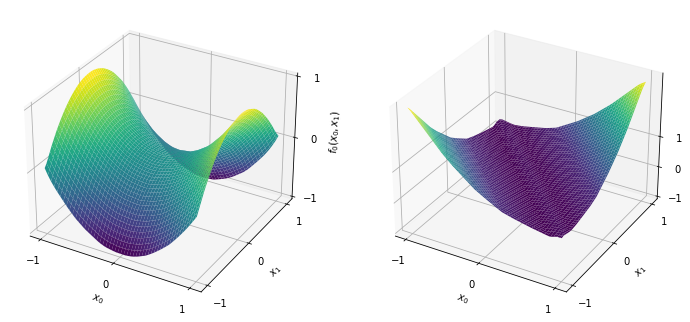

In [ ]:
NetPlot(net_DegenerateR,Name="net_DegenerateR")

# Plots

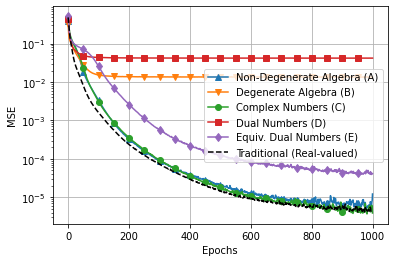

In [ ]:
# plt.figure(figsize=(12,8))

plt.semilogy(h_NonDegenerateR.history['loss'],'-^',label="Non-Degenerate Algebra (A)",markevery=50)
plt.semilogy(h_DegenerateR.history['loss'],'-v',label="Degenerate Algebra (B)",markevery=50)
plt.semilogy(h_ComplexR.history['loss'],'-o',label="Complex Numbers (C)",markevery=50)
plt.semilogy(h_DualR.history['loss'],'-s',label="Dual Numbers (D)",markevery=50)
plt.semilogy(h_Dual2R.history['loss'],'-d',label="Equiv. Dual Numbers (E)",markevery=50)
plt.semilogy(h_Real.history['loss'],'--k',label="Traditional (Real-valued)")
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.savefig("Figures2D/Experiment_2D_R.pdf")

Text(0, 0.5, 'Maximum Error')

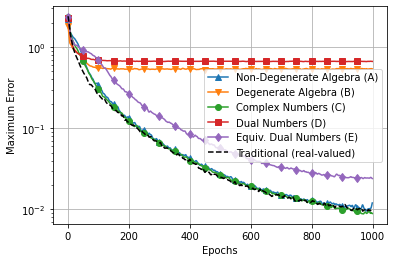

In [ ]:
# plt.figure(figsize=(12,8))

sigma = 2
plt.semilogy(gaussian_filter1d(h_NonDegenerateR.history['MaxAbs'],sigma),'-^',label="Non-Degenerate Algebra (A)",markevery=50)
plt.semilogy(gaussian_filter1d(h_DegenerateR.history['MaxAbs'],sigma),'-v',label="Degenerate Algebra (B)",markevery=50)
plt.semilogy(gaussian_filter1d(h_ComplexR.history['MaxAbs'],sigma),'-o',label="Complex Numbers (C)",markevery=50)
plt.semilogy(gaussian_filter1d(h_DualR.history['MaxAbs'],sigma),'-s',label="Dual Numbers (D)",markevery=50)
plt.semilogy(gaussian_filter1d(h_Dual2R.history['MaxAbs'],sigma),'-d',label="Equiv. Dual Numbers (E)",markevery=50)
plt.semilogy(gaussian_filter1d(h_Real.history['MaxAbs'],sigma),'--k',label="Traditional (real-valued)",markevery=50)

plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Maximum Error")

# plt.savefig("Figures2D/Experiment_2D_R.pdf")

# Evalulate a hypercomplex network with vector product in the output layer

In [ ]:
def EvalHypercomplexNetworkV(algebra,Xtr,ytr):
    kr.backend.clear_session()

    MLP_network = kr.Sequential([kr.layers.Input(shape=(Xtr.shape[1],)),
                            V_Dense(Nunits, activation='relu', algebra=algebra),
                            V_Dense(1, algebra=algebra, use_bias=False, activation = None)])
    print(MLP_network.summary())
    MLP_network.compile(optimizer=opt_method,loss='mse',metrics=[MaxAbs])
    return MLP_network.fit(Xtr,ytr, epochs=Nepochs, verbose = 1, batch_size=128), MLP_network

In [ ]:
h_ComplexV, net_ComplexV = EvalHypercomplexNetworkV(ComplexNumbers,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__dense_1 (V_Dense)        (None, 2)                 256       
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.4297 - MaxAbs: 2.4779
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3242 - MaxAbs: 2.2134
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2485 - MaxAbs: 1.9837
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1939 - MaxAbs: 1.7598
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - MaxAbs: 0.2359
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - MaxAbs: 0.2539
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - MaxAbs: 0.2140
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0017 - MaxAbs: 0.2429
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0017 - MaxAbs: 0.2122
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - MaxAbs: 0.2294
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - MaxAbs: 0.2197
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - MaxAbs: 0.2362
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - MaxAbs: 0.1829
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - MaxAbs: 0.2123
Epoch 88/1000
8/8 [=========================

8/8 [==============================] - 0s 2ms/step - loss: 2.6393e-04 - MaxAbs: 0.1088
Epoch 160/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5921e-04 - MaxAbs: 0.0992
Epoch 161/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.5360e-04 - MaxAbs: 0.1022
Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.4720e-04 - MaxAbs: 0.1013
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.4491e-04 - MaxAbs: 0.0981
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.4085e-04 - MaxAbs: 0.0996
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.3121e-04 - MaxAbs: 0.1044
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2708e-04 - MaxAbs: 0.1067
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2442e-04 - MaxAbs: 0.1036
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.2034e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 7.8869e-05 - MaxAbs: 0.0649
Epoch 240/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6583e-05 - MaxAbs: 0.0640
Epoch 241/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.5823e-05 - MaxAbs: 0.0542
Epoch 242/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3884e-05 - MaxAbs: 0.0571
Epoch 243/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3022e-05 - MaxAbs: 0.0577
Epoch 244/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2351e-05 - MaxAbs: 0.0572
Epoch 245/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1981e-05 - MaxAbs: 0.0561
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0618e-05 - MaxAbs: 0.0534
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0326e-05 - MaxAbs: 0.0620
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.9661e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 3.1536e-05 - MaxAbs: 0.0316
Epoch 320/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.1312e-05 - MaxAbs: 0.0394
Epoch 321/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.1230e-05 - MaxAbs: 0.0360
Epoch 322/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.1140e-05 - MaxAbs: 0.0400
Epoch 323/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.0801e-05 - MaxAbs: 0.0339
Epoch 324/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.0002e-05 - MaxAbs: 0.0347
Epoch 325/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.9842e-05 - MaxAbs: 0.0377
Epoch 326/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.0660e-05 - MaxAbs: 0.0356
Epoch 327/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.1004e-05 - MaxAbs: 0.0336
Epoch 328/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.9914e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.5871e-05 - MaxAbs: 0.0256
Epoch 400/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5748e-05 - MaxAbs: 0.0251
Epoch 401/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5915e-05 - MaxAbs: 0.0240
Epoch 402/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6027e-05 - MaxAbs: 0.0255
Epoch 403/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5787e-05 - MaxAbs: 0.0252
Epoch 404/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5652e-05 - MaxAbs: 0.0264
Epoch 405/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5736e-05 - MaxAbs: 0.0236
Epoch 406/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5806e-05 - MaxAbs: 0.0222
Epoch 407/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5361e-05 - MaxAbs: 0.0240
Epoch 408/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5226e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.0824e-05 - MaxAbs: 0.0181
Epoch 480/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0005e-05 - MaxAbs: 0.0181
Epoch 481/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.9623e-06 - MaxAbs: 0.0177
Epoch 482/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.7923e-06 - MaxAbs: 0.0187
Epoch 483/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.6893e-06 - MaxAbs: 0.0192
Epoch 484/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.7489e-06 - MaxAbs: 0.0174
Epoch 485/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.8974e-06 - MaxAbs: 0.0184
Epoch 486/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0266e-05 - MaxAbs: 0.0193
Epoch 487/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.5313e-06 - MaxAbs: 0.0183
Epoch 488/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.5983e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 7.9654e-06 - MaxAbs: 0.0156
Epoch 560/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6649e-06 - MaxAbs: 0.0137
Epoch 561/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4156e-06 - MaxAbs: 0.0144
Epoch 562/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4536e-06 - MaxAbs: 0.0141
Epoch 563/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.3142e-06 - MaxAbs: 0.0164
Epoch 564/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0285e-06 - MaxAbs: 0.0146
Epoch 565/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.9540e-06 - MaxAbs: 0.0150
Epoch 566/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4893e-06 - MaxAbs: 0.0156
Epoch 567/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0008e-06 - MaxAbs: 0.0153
Epoch 568/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.7946e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 5.1625e-06 - MaxAbs: 0.0133
Epoch 640/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.3686e-06 - MaxAbs: 0.0114
Epoch 641/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.3211e-06 - MaxAbs: 0.0129
Epoch 642/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.0939e-06 - MaxAbs: 0.0124
Epoch 643/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.6646e-06 - MaxAbs: 0.0126
Epoch 644/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.6425e-06 - MaxAbs: 0.0128
Epoch 645/1000
8/8 [==============================] - 0s 3ms/step - loss: 5.3882e-06 - MaxAbs: 0.0112
Epoch 646/1000
8/8 [==============================] - 0s 3ms/step - loss: 5.5172e-06 - MaxAbs: 0.0122
Epoch 647/1000
8/8 [==============================] - 0s 3ms/step - loss: 5.0863e-06 - MaxAbs: 0.0113
Epoch 648/1000
8/8 [==============================] - 0s 3ms/step - loss: 4.9360e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 3ms/step - loss: 4.8206e-06 - MaxAbs: 0.0098
Epoch 720/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0240e-06 - MaxAbs: 0.0098
Epoch 721/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.8858e-06 - MaxAbs: 0.0103
Epoch 722/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.8401e-06 - MaxAbs: 0.0094
Epoch 723/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0376e-06 - MaxAbs: 0.0101
Epoch 724/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.1056e-06 - MaxAbs: 0.0102
Epoch 725/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.9509e-06 - MaxAbs: 0.0103
Epoch 726/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.8423e-06 - MaxAbs: 0.0100
Epoch 727/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.7842e-06 - MaxAbs: 0.0091
Epoch 728/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0355e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 3.7706e-06 - MaxAbs: 0.0080
Epoch 800/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.4958e-06 - MaxAbs: 0.0089
Epoch 801/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.0530e-06 - MaxAbs: 0.0087
Epoch 802/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.2663e-06 - MaxAbs: 0.0086
Epoch 803/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.2234e-06 - MaxAbs: 0.0087
Epoch 804/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.3161e-06 - MaxAbs: 0.0086
Epoch 805/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.2633e-06 - MaxAbs: 0.0084
Epoch 806/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.9450e-06 - MaxAbs: 0.0087
Epoch 807/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.1950e-06 - MaxAbs: 0.0078
Epoch 808/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.7976e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 3.0924e-06 - MaxAbs: 0.0081
Epoch 880/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.2788e-06 - MaxAbs: 0.0079
Epoch 881/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5457e-06 - MaxAbs: 0.0080
Epoch 882/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6488e-06 - MaxAbs: 0.0079
Epoch 883/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.1618e-06 - MaxAbs: 0.0077
Epoch 884/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.8727e-06 - MaxAbs: 0.0069
Epoch 885/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.1265e-06 - MaxAbs: 0.0081
Epoch 886/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.1336e-06 - MaxAbs: 0.0081
Epoch 887/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.1514e-06 - MaxAbs: 0.0080
Epoch 888/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.7481e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 2.6908e-06 - MaxAbs: 0.0065
Epoch 960/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5184e-06 - MaxAbs: 0.0072
Epoch 961/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5969e-06 - MaxAbs: 0.0068
Epoch 962/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6428e-06 - MaxAbs: 0.0068
Epoch 963/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.4094e-06 - MaxAbs: 0.0067
Epoch 964/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.0903e-06 - MaxAbs: 0.0072
Epoch 965/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.0921e-06 - MaxAbs: 0.0066
Epoch 966/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.2678e-06 - MaxAbs: 0.0069
Epoch 967/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6988e-06 - MaxAbs: 0.0066
Epoch 968/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5067e-06 - MaxAbs: 0.

313/313 [==============================] - 0s 855us/step


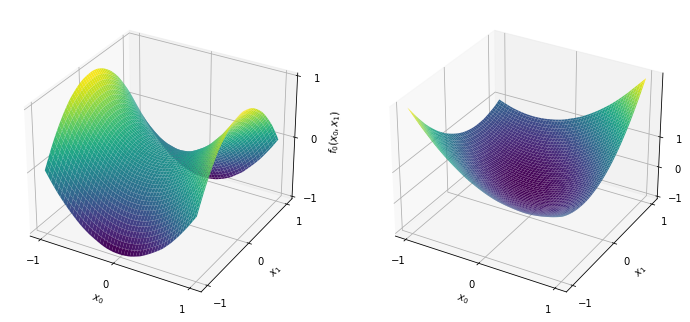

In [ ]:
NetPlot(net_ComplexV,Name="net_ComplexV")

In [ ]:
h_DualV, net_DualV = EvalHypercomplexNetworkV(DualNumbers,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__dense_1 (V_Dense)        (None, 2)                 256       
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.4164 - MaxAbs: 2.5205
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3164 - MaxAbs: 2.2134
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2445 - MaxAbs: 2.0909
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1953 - MaxAbs: 1.8822
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0440 - MaxAbs: 0.6782
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0439 - MaxAbs: 0.6828
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0439 - MaxAbs: 0.6839
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0439 - MaxAbs: 0.6745
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0438 - MaxAbs: 0.7006
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0438 - MaxAbs: 0.6806
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0437 - MaxAbs: 0.6763
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0437 - MaxAbs: 0.6920
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0437 - MaxAbs: 0.6921
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0437 - MaxAbs: 0.6883
Epoch 88/1000
8/8 [=========================

Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0426 - MaxAbs: 0.6680
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0427 - MaxAbs: 0.6720
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0426 - MaxAbs: 0.6733
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0426 - MaxAbs: 0.6660
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0426 - MaxAbs: 0.6631
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0426 - MaxAbs: 0.6710
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0425 - MaxAbs: 0.6749
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0426 - MaxAbs: 0.6746
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0426 - MaxAbs: 0.6724
Epoch 171/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0425 - MaxAbs: 0.6716
Epoch 172/1000
8/8 [

8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6723
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6677
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6642
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6658
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6774
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6652
Epoch 251/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6707
Epoch 252/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6561
Epoch 253/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6646
Epoch 254/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6654
Epoch 255/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6676
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6741
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6666
Epoch 331/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0424 - MaxAbs: 0.6639
Epoch 332/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6614
Epoch 333/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6631
Epoch 334/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6685
Epoch 335/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6648
Epoch 336/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6689
Epoch 337/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6641
Epoch 338/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6698
Epoch 412/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6610
Epoch 413/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6700
Epoch 414/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6706
Epoch 415/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6673
Epoch 416/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6698
Epoch 417/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6627
Epoch 418/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6674
Epoch 419/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6701
Epoch 420/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6639
Epoch 421/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6627
Epoch 495/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6662
Epoch 496/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6689
Epoch 497/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6705
Epoch 498/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6582
Epoch 499/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6660
Epoch 500/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6695
Epoch 501/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6581
Epoch 502/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6668
Epoch 503/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6681
Epoch 504/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6592
Epoch 578/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6665
Epoch 579/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6643
Epoch 580/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6643
Epoch 581/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6580
Epoch 582/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6565
Epoch 583/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6704
Epoch 584/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6635
Epoch 585/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6634
Epoch 586/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6686
Epoch 587/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6720
Epoch 661/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6721
Epoch 662/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6609
Epoch 663/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6639
Epoch 664/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6605
Epoch 665/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6677
Epoch 666/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6653
Epoch 667/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6589
Epoch 668/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6626
Epoch 669/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6627
Epoch 670/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6627
Epoch 744/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6592
Epoch 745/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6719
Epoch 746/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6634
Epoch 747/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6672
Epoch 748/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6694
Epoch 749/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6611
Epoch 750/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6682
Epoch 751/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6661
Epoch 752/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6581
Epoch 753/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6614
Epoch 827/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6701
Epoch 828/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6517
Epoch 829/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6532
Epoch 830/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6680
Epoch 831/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6710
Epoch 832/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6625
Epoch 833/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6588
Epoch 834/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6708
Epoch 835/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6721
Epoch 836/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6537
Epoch 910/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0420 - MaxAbs: 0.6652
Epoch 911/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6769
Epoch 912/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6655
Epoch 913/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6562
Epoch 914/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0420 - MaxAbs: 0.6576
Epoch 915/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0422 - MaxAbs: 0.6692
Epoch 916/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0423 - MaxAbs: 0.6702
Epoch 917/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6546
Epoch 918/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6664
Epoch 919/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6537
Epoch 993/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0420 - MaxAbs: 0.6681
Epoch 994/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6694
Epoch 995/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6672
Epoch 996/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0420 - MaxAbs: 0.6646
Epoch 997/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6576
Epoch 998/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6518
Epoch 999/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0420 - MaxAbs: 0.6677
Epoch 1000/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0421 - MaxAbs: 0.6623


313/313 [==============================] - 0s 838us/step


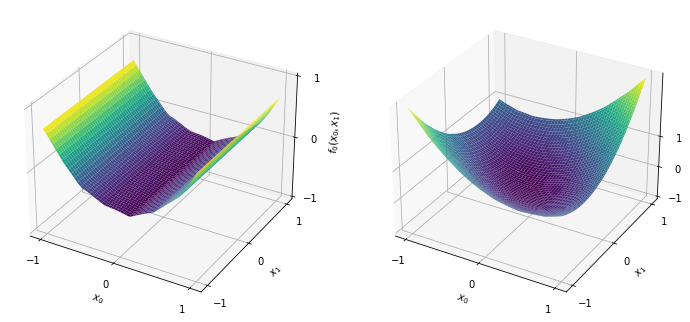

In [ ]:
NetPlot(net_DualV,Name="net_DualV")

In [ ]:
h_Dual2V, net_Dual2V = EvalHypercomplexNetworkV(DualNumbers2,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__dense_1 (V_Dense)        (None, 2)                 256       
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.4037 - MaxAbs: 2.4432
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2568 - MaxAbs: 1.9740
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1736 - MaxAbs: 1.5815
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1336 - MaxAbs: 1.3574
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0028 - MaxAbs: 0.2387
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0028 - MaxAbs: 0.2490
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0027 - MaxAbs: 0.2477
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0027 - MaxAbs: 0.2446
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0026 - MaxAbs: 0.2422
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0025 - MaxAbs: 0.2446
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0024 - MaxAbs: 0.2344
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0023 - MaxAbs: 0.2294
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0023 - MaxAbs: 0.2331
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0022 - MaxAbs: 0.2321
Epoch 88/1000
8/8 [=========================

8/8 [==============================] - 0s 2ms/step - loss: 3.8384e-04 - MaxAbs: 0.1195
Epoch 161/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.7403e-04 - MaxAbs: 0.1252
Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6962e-04 - MaxAbs: 0.1093
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6162e-04 - MaxAbs: 0.1200
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5506e-04 - MaxAbs: 0.1150
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.5127e-04 - MaxAbs: 0.1116
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.4413e-04 - MaxAbs: 0.1121
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.3734e-04 - MaxAbs: 0.1165
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.3763e-04 - MaxAbs: 0.1107
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.2522e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.1454e-04 - MaxAbs: 0.0706
Epoch 241/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1393e-04 - MaxAbs: 0.0714
Epoch 242/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0963e-04 - MaxAbs: 0.0688
Epoch 243/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1066e-04 - MaxAbs: 0.0641
Epoch 244/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0936e-04 - MaxAbs: 0.0619
Epoch 245/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0808e-04 - MaxAbs: 0.0686
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0703e-04 - MaxAbs: 0.0701
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0704e-04 - MaxAbs: 0.0665
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0422e-04 - MaxAbs: 0.0698
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0292e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 4.9604e-05 - MaxAbs: 0.0493
Epoch 321/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.9083e-05 - MaxAbs: 0.0472
Epoch 322/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.8839e-05 - MaxAbs: 0.0491
Epoch 323/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7857e-05 - MaxAbs: 0.0450
Epoch 324/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7631e-05 - MaxAbs: 0.0466
Epoch 325/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7050e-05 - MaxAbs: 0.0508
Epoch 326/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.5921e-05 - MaxAbs: 0.0482
Epoch 327/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.6064e-05 - MaxAbs: 0.0423
Epoch 328/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.4715e-05 - MaxAbs: 0.0484
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.5133e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 2.6476e-05 - MaxAbs: 0.0366
Epoch 401/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5550e-05 - MaxAbs: 0.0316
Epoch 402/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5418e-05 - MaxAbs: 0.0337
Epoch 403/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6189e-05 - MaxAbs: 0.0328
Epoch 404/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5173e-05 - MaxAbs: 0.0343
Epoch 405/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5397e-05 - MaxAbs: 0.0363
Epoch 406/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5687e-05 - MaxAbs: 0.0309
Epoch 407/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6062e-05 - MaxAbs: 0.0342
Epoch 408/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5147e-05 - MaxAbs: 0.0308
Epoch 409/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5237e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.6589e-05 - MaxAbs: 0.0259
Epoch 481/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6146e-05 - MaxAbs: 0.0240
Epoch 482/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5276e-05 - MaxAbs: 0.0257
Epoch 483/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6116e-05 - MaxAbs: 0.0254
Epoch 484/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6529e-05 - MaxAbs: 0.0261
Epoch 485/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.5948e-05 - MaxAbs: 0.0247
Epoch 486/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6768e-05 - MaxAbs: 0.0272
Epoch 487/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7306e-05 - MaxAbs: 0.0271
Epoch 488/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.8350e-05 - MaxAbs: 0.0243
Epoch 489/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7071e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.2333e-05 - MaxAbs: 0.0224
Epoch 561/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.3550e-05 - MaxAbs: 0.0201
Epoch 562/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2899e-05 - MaxAbs: 0.0215
Epoch 563/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0874e-05 - MaxAbs: 0.0184
Epoch 564/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1572e-05 - MaxAbs: 0.0189
Epoch 565/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1933e-05 - MaxAbs: 0.0191
Epoch 566/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1407e-05 - MaxAbs: 0.0196
Epoch 567/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1330e-05 - MaxAbs: 0.0191
Epoch 568/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2563e-05 - MaxAbs: 0.0205
Epoch 569/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1616e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.0620e-05 - MaxAbs: 0.0171
Epoch 641/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.9010e-06 - MaxAbs: 0.0171
Epoch 642/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.2334e-06 - MaxAbs: 0.0162
Epoch 643/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.0383e-06 - MaxAbs: 0.0161
Epoch 644/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0327e-05 - MaxAbs: 0.0158
Epoch 645/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3698e-06 - MaxAbs: 0.0170
Epoch 646/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.8396e-06 - MaxAbs: 0.0165
Epoch 647/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.4614e-06 - MaxAbs: 0.0150
Epoch 648/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.2140e-06 - MaxAbs: 0.0173
Epoch 649/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.8813e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 8.0233e-06 - MaxAbs: 0.0134
Epoch 721/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4693e-06 - MaxAbs: 0.0157
Epoch 722/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6159e-06 - MaxAbs: 0.0139
Epoch 723/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.7027e-06 - MaxAbs: 0.0140
Epoch 724/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.9564e-06 - MaxAbs: 0.0129
Epoch 725/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2199e-06 - MaxAbs: 0.0128
Epoch 726/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.2717e-06 - MaxAbs: 0.0142
Epoch 727/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.5601e-06 - MaxAbs: 0.0137
Epoch 728/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0642e-06 - MaxAbs: 0.0127
Epoch 729/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.0076e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 7.2629e-06 - MaxAbs: 0.0118
Epoch 801/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.9351e-06 - MaxAbs: 0.0134
Epoch 802/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.8523e-06 - MaxAbs: 0.0128
Epoch 803/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.7558e-06 - MaxAbs: 0.0128
Epoch 804/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2954e-06 - MaxAbs: 0.0124
Epoch 805/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6944e-06 - MaxAbs: 0.0132
Epoch 806/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.8279e-06 - MaxAbs: 0.0131
Epoch 807/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.1488e-06 - MaxAbs: 0.0124
Epoch 808/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.9394e-06 - MaxAbs: 0.0132
Epoch 809/1000
8/8 [==============================] - 0s 3ms/step - loss: 8.3762e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 7.0109e-06 - MaxAbs: 0.0117
Epoch 881/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2761e-06 - MaxAbs: 0.0117
Epoch 882/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.7925e-06 - MaxAbs: 0.0108
Epoch 883/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4276e-06 - MaxAbs: 0.0122
Epoch 884/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2846e-06 - MaxAbs: 0.0120
Epoch 885/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1174e-06 - MaxAbs: 0.0112
Epoch 886/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.7323e-06 - MaxAbs: 0.0119
Epoch 887/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.3409e-06 - MaxAbs: 0.0125
Epoch 888/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.7291e-06 - MaxAbs: 0.0114
Epoch 889/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.5766e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 6.3651e-06 - MaxAbs: 0.0118
Epoch 961/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.9843e-06 - MaxAbs: 0.0098
Epoch 962/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.3364e-06 - MaxAbs: 0.0110
Epoch 963/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.2990e-06 - MaxAbs: 0.0103
Epoch 964/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.0617e-06 - MaxAbs: 0.0110
Epoch 965/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.2281e-06 - MaxAbs: 0.0113
Epoch 966/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.6115e-06 - MaxAbs: 0.0105
Epoch 967/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.1124e-06 - MaxAbs: 0.0108
Epoch 968/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.4899e-06 - MaxAbs: 0.0111
Epoch 969/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.1038e-06 - MaxAbs: 0.

313/313 [==============================] - 0s 883us/step


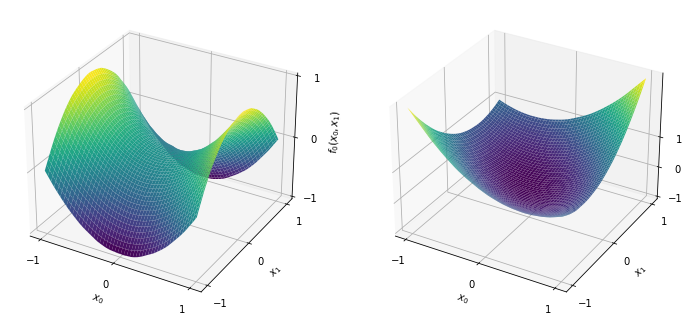

In [ ]:
NetPlot(net_Dual2V,Name="net_Dual2V")

In [ ]:
h_NonDegenerateV, net_NonDegenerateV = EvalHypercomplexNetworkV(NonDegenerate,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__dense_1 (V_Dense)        (None, 2)                 256       
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 2ms/step - loss: 0.4029 - MaxAbs: 2.4467
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3369 - MaxAbs: 2.2752
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3117 - MaxAbs: 2.1431
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3002 - MaxAbs: 2.0253
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.8615
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.9274
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.8799
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.9263
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.9113
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.8431
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.8436
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.8719
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.9067
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2302 - MaxAbs: 1.8910
Epoch 88/1000
8/8 [=========================

Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9058
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9123
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8554
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8833
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8983
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9252
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8728
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8752
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8750
Epoch 171/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8933
Epoch 172/1000
8/8 [

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8677
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9000
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9009
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8507
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8940
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9197
Epoch 251/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8497
Epoch 252/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8973
Epoch 253/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8812
Epoch 254/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8417
Epoch 255/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8849
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9107
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8767
Epoch 331/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9029
Epoch 332/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8457
Epoch 333/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8894
Epoch 334/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8745
Epoch 335/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9013
Epoch 336/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8771
Epoch 337/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8705
Epoch 338/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8693
Epoch 412/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8826
Epoch 413/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8413
Epoch 414/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8901
Epoch 415/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8605
Epoch 416/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8837
Epoch 417/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8637
Epoch 418/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9218
Epoch 419/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8869
Epoch 420/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8876
Epoch 421/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8986
Epoch 495/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8393
Epoch 496/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8805
Epoch 497/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8874
Epoch 498/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8518
Epoch 499/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8949
Epoch 500/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8744
Epoch 501/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8814
Epoch 502/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9043
Epoch 503/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8641
Epoch 504/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9273
Epoch 578/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8823
Epoch 579/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8987
Epoch 580/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8698
Epoch 581/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8278
Epoch 582/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8795
Epoch 583/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9036
Epoch 584/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8951
Epoch 585/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8207
Epoch 586/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8781
Epoch 587/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8998
Epoch 661/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9194
Epoch 662/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9087
Epoch 663/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9204
Epoch 664/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8482
Epoch 665/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8885
Epoch 666/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8842
Epoch 667/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9015
Epoch 668/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8781
Epoch 669/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8985
Epoch 670/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8916
Epoch 744/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8804
Epoch 745/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8983
Epoch 746/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8738
Epoch 747/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8592
Epoch 748/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8903
Epoch 749/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9233
Epoch 750/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8775
Epoch 751/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8877
Epoch 752/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9200
Epoch 753/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8968
Epoch 827/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8809
Epoch 828/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8956
Epoch 829/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8541
Epoch 830/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8464
Epoch 831/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8353
Epoch 832/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8868
Epoch 833/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.2299 - MaxAbs: 1.8487
Epoch 834/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8548
Epoch 835/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8637
Epoch 836/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8811
Epoch 910/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8386
Epoch 911/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8873
Epoch 912/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8644
Epoch 913/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8448
Epoch 914/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8689
Epoch 915/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8717
Epoch 916/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8814
Epoch 917/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8738
Epoch 918/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8960
Epoch 919/1000
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9358
Epoch 993/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8806
Epoch 994/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8346
Epoch 995/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.9122
Epoch 996/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8698
Epoch 997/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8645
Epoch 998/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8775
Epoch 999/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8787
Epoch 1000/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2299 - MaxAbs: 1.8934


313/313 [==============================] - 0s 833us/step


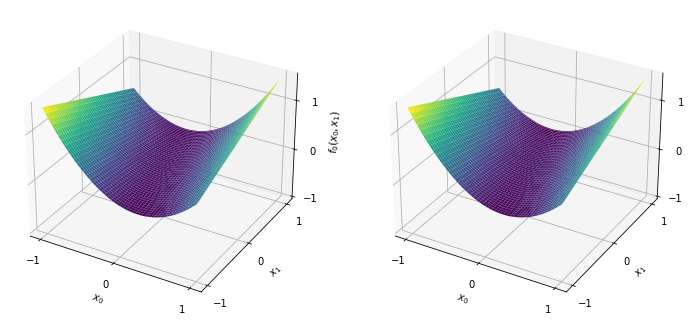

In [ ]:
NetPlot(net_NonDegenerateV,Name="net_NonDegenerate1V")

In [ ]:
h_DegenerateV, net_DegenerateV = EvalHypercomplexNetworkV(Degenerate,Xtr,ytr)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense (V_Dense)          (None, 256)               512       
                                                                 
 v__dense_1 (V_Dense)        (None, 2)                 256       
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
8/8 [==============================] - 1s 3ms/step - loss: 0.3091 - MaxAbs: 2.0857
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1978 - MaxAbs: 1.5688
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1826 - MaxAbs: 1.4271
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.1678 - MaxAbs: 1.4027
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step -

8/8 [==============================] - 0s 2ms/step - loss: 0.0055 - MaxAbs: 0.3672
Epoch 79/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0052 - MaxAbs: 0.3589
Epoch 80/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0050 - MaxAbs: 0.3490
Epoch 81/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0048 - MaxAbs: 0.3586
Epoch 82/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0046 - MaxAbs: 0.3466
Epoch 83/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0045 - MaxAbs: 0.3317
Epoch 84/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0043 - MaxAbs: 0.3285
Epoch 85/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0042 - MaxAbs: 0.3313
Epoch 86/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0041 - MaxAbs: 0.3175
Epoch 87/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.0039 - MaxAbs: 0.3175
Epoch 88/1000
8/8 [=========================

8/8 [==============================] - 0s 2ms/step - loss: 8.8245e-04 - MaxAbs: 0.1770
Epoch 162/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.6928e-04 - MaxAbs: 0.1572
Epoch 163/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.7343e-04 - MaxAbs: 0.1518
Epoch 164/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.4983e-04 - MaxAbs: 0.1700
Epoch 165/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.2658e-04 - MaxAbs: 0.1568
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.1209e-04 - MaxAbs: 0.1551
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.9926e-04 - MaxAbs: 0.1553
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.8216e-04 - MaxAbs: 0.1514
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.7111e-04 - MaxAbs: 0.1598
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.5778e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 2.6050e-04 - MaxAbs: 0.0961
Epoch 242/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5841e-04 - MaxAbs: 0.0905
Epoch 243/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5649e-04 - MaxAbs: 0.0915
Epoch 244/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.5184e-04 - MaxAbs: 0.0929
Epoch 245/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.4808e-04 - MaxAbs: 0.0950
Epoch 246/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.4482e-04 - MaxAbs: 0.0943
Epoch 247/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.4189e-04 - MaxAbs: 0.0941
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.3783e-04 - MaxAbs: 0.0971
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.3703e-04 - MaxAbs: 0.0939
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.3268e-04 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.0744e-04 - MaxAbs: 0.0647
Epoch 322/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0661e-04 - MaxAbs: 0.0642
Epoch 323/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0489e-04 - MaxAbs: 0.0609
Epoch 324/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0251e-04 - MaxAbs: 0.0630
Epoch 325/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.9894e-05 - MaxAbs: 0.0619
Epoch 326/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.8788e-05 - MaxAbs: 0.0565
Epoch 327/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.9105e-05 - MaxAbs: 0.0582
Epoch 328/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.7492e-05 - MaxAbs: 0.0615
Epoch 329/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.6980e-05 - MaxAbs: 0.0625
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.6733e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 4.9558e-05 - MaxAbs: 0.0498
Epoch 402/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.0452e-05 - MaxAbs: 0.0483
Epoch 403/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.9447e-05 - MaxAbs: 0.0476
Epoch 404/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.9582e-05 - MaxAbs: 0.0432
Epoch 405/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.8305e-05 - MaxAbs: 0.0424
Epoch 406/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7656e-05 - MaxAbs: 0.0419
Epoch 407/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7821e-05 - MaxAbs: 0.0438
Epoch 408/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7887e-05 - MaxAbs: 0.0493
Epoch 409/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.6885e-05 - MaxAbs: 0.0434
Epoch 410/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.7074e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 2.7256e-05 - MaxAbs: 0.0328
Epoch 482/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6948e-05 - MaxAbs: 0.0361
Epoch 483/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6723e-05 - MaxAbs: 0.0336
Epoch 484/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6992e-05 - MaxAbs: 0.0317
Epoch 485/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.7341e-05 - MaxAbs: 0.0332
Epoch 486/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.6976e-05 - MaxAbs: 0.0327
Epoch 487/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.8093e-05 - MaxAbs: 0.0327
Epoch 488/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.9004e-05 - MaxAbs: 0.0332
Epoch 489/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.9695e-05 - MaxAbs: 0.0334
Epoch 490/1000
8/8 [==============================] - 0s 2ms/step - loss: 2.9016e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.9080e-05 - MaxAbs: 0.0279
Epoch 562/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.8094e-05 - MaxAbs: 0.0261
Epoch 563/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7643e-05 - MaxAbs: 0.0237
Epoch 564/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6666e-05 - MaxAbs: 0.0243
Epoch 565/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6466e-05 - MaxAbs: 0.0235
Epoch 566/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7143e-05 - MaxAbs: 0.0253
Epoch 567/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.8677e-05 - MaxAbs: 0.0251
Epoch 568/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7039e-05 - MaxAbs: 0.0269
Epoch 569/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7036e-05 - MaxAbs: 0.0231
Epoch 570/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7648e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.2005e-05 - MaxAbs: 0.0213
Epoch 642/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2733e-05 - MaxAbs: 0.0210
Epoch 643/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6751e-05 - MaxAbs: 0.0205
Epoch 644/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.7263e-05 - MaxAbs: 0.0209
Epoch 645/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2324e-05 - MaxAbs: 0.0216
Epoch 646/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1684e-05 - MaxAbs: 0.0188
Epoch 647/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2021e-05 - MaxAbs: 0.0180
Epoch 648/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2044e-05 - MaxAbs: 0.0198
Epoch 649/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4906e-05 - MaxAbs: 0.0189
Epoch 650/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2441e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 9.4128e-06 - MaxAbs: 0.0169
Epoch 722/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.5992e-06 - MaxAbs: 0.0173
Epoch 723/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.3095e-06 - MaxAbs: 0.0155
Epoch 724/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.2818e-06 - MaxAbs: 0.0148
Epoch 725/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.8638e-06 - MaxAbs: 0.0163
Epoch 726/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0809e-05 - MaxAbs: 0.0154
Epoch 727/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0642e-05 - MaxAbs: 0.0171
Epoch 728/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3158e-06 - MaxAbs: 0.0170
Epoch 729/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.8499e-06 - MaxAbs: 0.0162
Epoch 730/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4944e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 1.0289e-05 - MaxAbs: 0.0152
Epoch 802/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1364e-05 - MaxAbs: 0.0148
Epoch 803/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.1890e-06 - MaxAbs: 0.0137
Epoch 804/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.9420e-06 - MaxAbs: 0.0137
Epoch 805/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.4005e-06 - MaxAbs: 0.0137
Epoch 806/1000
8/8 [==============================] - 0s 2ms/step - loss: 8.9748e-06 - MaxAbs: 0.0130
Epoch 807/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.7746e-06 - MaxAbs: 0.0145
Epoch 808/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0429e-05 - MaxAbs: 0.0150
Epoch 809/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1049e-05 - MaxAbs: 0.0146
Epoch 810/1000
8/8 [==============================] - 0s 2ms/step - loss: 6.8318e-06 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 4.9615e-06 - MaxAbs: 0.0112
Epoch 882/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.1818e-06 - MaxAbs: 0.0111
Epoch 883/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6851e-06 - MaxAbs: 0.0118
Epoch 884/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.0084e-05 - MaxAbs: 0.0118
Epoch 885/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.1841e-06 - MaxAbs: 0.0120
Epoch 886/1000
8/8 [==============================] - 0s 2ms/step - loss: 7.6272e-06 - MaxAbs: 0.0118
Epoch 887/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2787e-05 - MaxAbs: 0.0140
Epoch 888/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.3762e-05 - MaxAbs: 0.0138
Epoch 889/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1155e-05 - MaxAbs: 0.0150
Epoch 890/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.1500e-05 - MaxAbs: 0.

8/8 [==============================] - 0s 2ms/step - loss: 4.1075e-06 - MaxAbs: 0.0094
Epoch 962/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0484e-06 - MaxAbs: 0.0103
Epoch 963/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.6379e-06 - MaxAbs: 0.0102
Epoch 964/1000
8/8 [==============================] - 0s 2ms/step - loss: 5.3658e-06 - MaxAbs: 0.0110
Epoch 965/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.5852e-06 - MaxAbs: 0.0091
Epoch 966/1000
8/8 [==============================] - 0s 2ms/step - loss: 4.0504e-06 - MaxAbs: 0.0093
Epoch 967/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.8361e-06 - MaxAbs: 0.0092
Epoch 968/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.9950e-06 - MaxAbs: 0.0099
Epoch 969/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.9490e-06 - MaxAbs: 0.0098
Epoch 970/1000
8/8 [==============================] - 0s 2ms/step - loss: 3.6724e-06 - MaxAbs: 0.

313/313 [==============================] - 0s 796us/step


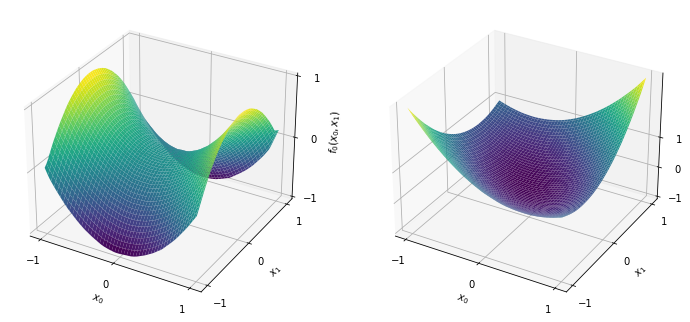

In [ ]:
NetPlot(net_DegenerateV,Name="net_DegenerateV")

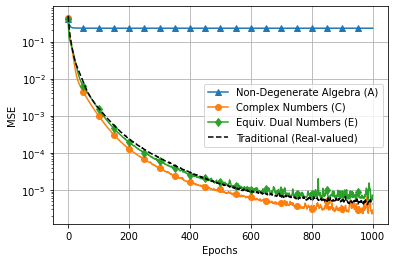

In [ ]:
# plt.figure(figsize=(12,8))
# plt.semilogy(h_Real.history['loss'],label="Real")

plt.semilogy(h_NonDegenerateV.history['loss'],'-^',label="Non-Degenerate Algebra (A)",markevery=50)
# plt.semilogy(h_DegenerateV.history['loss'],'-v',label="Degenerate Algebra (B)",markevery=50)
plt.semilogy(h_ComplexV.history['loss'],'-o',label="Complex Numbers (C)",markevery=50)
# plt.semilogy(h_DualV.history['loss'],'-s',label="Dual Numbers (D)",markevery=50)
plt.semilogy(h_Dual2V.history['loss'],'-d',label="Equiv. Dual Numbers (E)",markevery=50)
plt.semilogy(h_Real.history['loss'],'--k',label="Traditional (Real-valued)")
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.savefig("Figures2D/Experiment_2D_V.pdf")

Text(0, 0.5, 'Maximum Error')

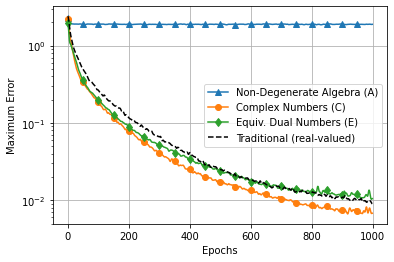

In [ ]:
sigma = 2

#plt.figure(figsize=(12,8))
# plt.semilogy(h_Real.history['loss'],label="Real")

plt.semilogy(gaussian_filter1d(h_NonDegenerateV.history['MaxAbs'],sigma),'-^',label="Non-Degenerate Algebra (A)",markevery=50)
# plt.semilogy(gaussian_filter1d(h_DegenerateV.history['MaxAbs'],sigma),'-v',label="Degenerate Algebra (B)",markevery=50)
plt.semilogy(gaussian_filter1d(h_ComplexV.history['MaxAbs'],sigma),'-o',label="Complex Numbers (C)",markevery=50)
# plt.semilogy(gaussian_filter1d(h_DualV.history['MaxAbs'],sigma),'-s',label="Dual Numbers (D)",markevery=50)
plt.semilogy(gaussian_filter1d(h_Dual2V.history['MaxAbs'],sigma),'-d',label="Equiv. Dual Numbers (E)",markevery=50)
plt.semilogy(gaussian_filter1d(h_Real.history['MaxAbs'],sigma),'--k',label="Traditional (real-valued)",markevery=50)
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Maximum Error")

# plt.savefig("Figures2D/Experiment_2D_V.pdf")

# Errors produced by the networks with real-valued output weights

In [ ]:
print("MSE (A): %2.2e" % h_NonDegenerateR.history['loss'][-1])
print("MSE (B): %2.2e" % h_DegenerateR.history['loss'][-1])
print("MSE (C): %2.2e" % h_ComplexR.history['loss'][-1])
print("MSE (D): %2.2e" % h_DualR.history['loss'][-1])
print("MSE (E): %2.2e" % h_Dual2R.history['loss'][-1])
print("MSE (R): %2.2e" % h_Real.history['loss'][-1])

MSE (A): 1.22e-05
MSE (B): 1.35e-02
MSE (C): 3.88e-06
MSE (D): 4.21e-02
MSE (E): 4.13e-05
MSE (R): 4.10e-06


# Errors produced by the networks with vector-valued output weights

In [ ]:
print("MSE (A): %2.2e" % h_NonDegenerateV.history['loss'][-1])
print("MSE (C): %2.2e" % h_ComplexV.history['loss'][-1])
print("MSE (E): %2.2e" % h_Dual2V.history['loss'][-1])
print("MSE (R): %2.2e" % h_Real.history['loss'][-1])

MSE (A): 2.30e-01
MSE (C): 2.85e-06
MSE (E): 7.14e-06
MSE (R): 4.10e-06
